# Comparison to Post-Prediction Inference

The goal of this experiment is to compare prediction-powered inference and post-prediction inference (1). The baseline first fits a regression $r$ to predict $Y$ from $\hat{Y}$ on the gold-standard data set. Subsequently, the regression function is used to correct the imputed labels on the unlabeled data set. Confidence intervals are formed using the $r(\hat{Y}')$ as if they were gold-standard data.

The inferential goal is to investigate the relationship between age and income using US census data. The same problem is studied in the notebook [```census_income.ipynb```](https://github.com/aangelopoulos/ppi_py/blob/main/examples/census_income.ipynb).

1. S. Wang, T. H. McCormick, J. T. Leek, Methods for correcting inference based on outcomes predicted by machine learning. Proceedings of the National Academy of Sciences 117(48), 30266–30275 (2020).

### Import necessary packages

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys

sys.path.append(
    os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
)
import numpy as np
import pandas as pd
from ppi_py.datasets import load_dataset
from ppi_py import ppi_ols_ci, classical_ols_ci, postprediction_ols_ci
from tqdm import tqdm
from scipy.optimize import brentq
from statsmodels.regression.linear_model import OLS
from baseline_utils import *

### Import the census income data set

Load the data. The data set contains reported income (```Y```), predicted income (```Yhat```), and age and sex (```X```).

In [2]:
dataset_folder = "../data/"
data = load_dataset(dataset_folder, "census_income")
Y_total = data["Y"]
Yhat_total = data["Yhat"]
X_total = data["X"]

### Problem setup

Specify the error level (```alpha```), range of values for the labeled data set size (```ns```), and number of trials (```num_trials```).

Compute the ground-truth value of the estimand.

In [3]:
alpha = 0.1
n_total = Y_total.shape[0]  # Total number of labeled examples
ns = np.linspace(50, 1000, 10).astype(
    int
)  # Test for different numbers of labeled examples
num_trials = 50
coordinate = 0

# True mean (computed on all labels)
true_theta = OLS(Y_total, exog=X_total).fit().params[coordinate]

### Construct intervals

Form confidence intervals for all methods and problem parameters. A dataframe with the following columns is formed:
1. ```method``` (one of ```PPI```, ```Classical```, and ```Baseline```, where ```Baseline``` is the post-prediction inference baseline)
2. ```n``` (labeled data set size, takes values in ```ns```)
3. ```lower``` (lower endpoint of the confidence interval)
4. ```upper``` (upper endpoint of the confidence interval)
5. ```trial``` (index of trial, goes from ```0``` to ```num_trials-1```)

In [4]:
# Run prediction-powered inference and classical inference for many values of n
results = []
for i in tqdm(range(ns.shape[0])):
    for j in range(num_trials):
        # Prediction-Powered Inference
        n = ns[i]
        rand_idx = np.random.permutation(n_total)
        _Yhat = Yhat_total[rand_idx[:n]]
        _Y = Y_total[rand_idx[:n]]
        _X = X_total[rand_idx[:n]]
        _X_unlabeled = X_total[rand_idx[n:]]
        _Yhat_unlabeled = Yhat_total[rand_idx[n:]]

        # PPI interval
        ppi_ci = ppi_ols_ci(
            _X, _Y, _Yhat, _X_unlabeled, _Yhat_unlabeled, alpha=alpha
        )

        # Post-prediction interval
        postprediction_ci = postprediction_ols_ci(
            _Y, _Yhat, _X_unlabeled, _Yhat_unlabeled, alpha=alpha
        )

        # Classical interval
        classical_ci = classical_ols_ci(_X, _Y, alpha=alpha)

        # Append results
        results += [
            pd.DataFrame(
                [
                    {
                        "method": "PPI",
                        "n": n,
                        "lower": ppi_ci[0][coordinate],
                        "upper": ppi_ci[1][coordinate],
                        "trial": j,
                    }
                ]
            )
        ]

        results += [
            pd.DataFrame(
                [
                    {
                        "method": "Baseline",  # Post-prediction inference baseline
                        "n": n,
                        "lower": postprediction_ci[0][coordinate],
                        "upper": postprediction_ci[1][coordinate],
                        "trial": j,
                    }
                ]
            )
        ]

        results += [
            pd.DataFrame(
                [
                    {
                        "method": "Classical",
                        "n": n,
                        "lower": classical_ci[0][coordinate],
                        "upper": classical_ci[1][coordinate],
                        "trial": j,
                    }
                ]
            )
        ]

df = pd.concat(results, axis=0, ignore_index=True)
df["width"] = df["upper"] - df["lower"]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [40:53<00:00, 245.32s/it]


### Plot results

Plot:
1. Five randomly chosen intervals from the dataframe for PPI, classical inference, and the post-prediction inference baseline;
2. The average interval width for PPI, classical inference, and the post-prediction inference baseline. 

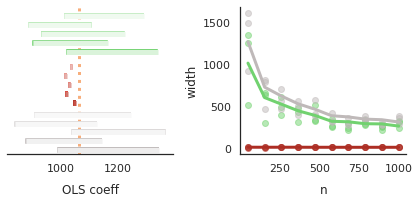

In [5]:
make_plots(
    df,
    "./plots/postprediction_census_ols_income.pdf",
    n_idx=-1,
    intervals_xlabel="OLS coeff",
    true_theta=true_theta,
)